In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import weibull_min, norm, geom, uniform, lognorm
from scipy.linalg import toeplitz, solve

# Utility functions

## Survival Curves

In [2]:
def fixed_sf(n, lifetime):
    """Compute the survival function (SF) of a fixed lifetime distribution.
    The fixed lifetime distribution models a random variable that always
    takes on a fixed value of lifetime, after which it becomes 0.

    Args:
        n: The number of integers to evaluate the SF at.
        lifetime: fixed lifetime

    Returns:
        An array of the survival function (SF) values of the fixed lifetime
        distribution evaluated at integers from 0 to n-1.
    """
    pdf = np.zeros(n)
    pdf[0:lifetime] = 1
    return pdf


def weibull_sf(n, shape=5, loc=0, scale=20):
    """Compute the survival function (SF) of the Weibull distribution.

    Args:
        n: The number of integers to evaluate the SF at.
        shape: determine the skewness of the distribution
            (shape < 1 = skewed to the right, shape>1 = skewed to the left)
        loc: determine the minimum value that the distribution can take)
        scale: determine the spread of the distribution (scale = shift along x-axis)

    Returns:
        An array of the survival function (SF) values of the Weibull distribution
        evaluated at integers from 0 to n-1.
    """
    x = np.arange(n)
    return weibull_min.sf(x, c=shape, loc=loc, scale=scale)


def normal_sf(n, loc=30, scale=10):
    """Compute the survival function (SF) of the normal distribution.

    Args:
        n: Number of integers to evaluate the SF at.
        loc: Mean of the normal distribution.
        scale: Standard deviation of the normal distribution.

    Returns:
        An array of the survival function (SF) values of the normal distribution
        evaluated at integers from 0 to n-1.
    """
    x = np.arange(n)
    return norm.sf(x, loc=loc, scale=scale)


def geometric_sf(n, p=0.05, loc=0):
    """Compute the survival function (SF) of the geometric distribution. The geometric
    distribution models the number of trials that must be performed before the first success
    in a sequence of independent Bernoulli trials with the same probability of success.

    Args:
        n: The number of integers to evaluate the SF at.
        p: The probability of success for each Bernoulli trial.
        loc: shift along x-axis (i.e. the number of failures before the first success)

    Returns:
        An array of the survival function (SF) values of the geometric distribution
        evaluated at integers from 0 to n-1.
    """
    k = np.arange(n)
    return geom.sf(k=k, p=p, loc=loc)


def uniform_sf(n, loc=0, scale=10):
    """Compute the survival function (SF) of the continuous uniform distribution.
    The continuous uniform distribution models a random variable that can take
    any value in a fixed interval with equal probability.

    Args:
        n: The number of integers to evaluate the SF at.
        loc: The lower endpoint of the uniform distribution's support.
        scale: The width of the uniform distribution's support
            (i.e., the range between the lower and upper endpoints).

    Returns:
        An array of the survival function (SF) values of the uniform distribution
        evaluated at integers from 0 to n-1.
    """
    x = np.arange(n)
    return uniform.sf(x, loc=loc, scale=scale)


def lognormal_sf(n, x=0.01, loc=0, scale=1):
    """Compute the survival function (SF) of the log-normal distribution.
    The log-normal distribution models a random variable whose natural logarithm
    follows a normal distribution.

    Args:
        n: The number of integers to evaluate the SF at.
        x: The value at which to evaluate the SF.
        loc: The mean of the logarithm of the distribution.
        scale: The standard deviation of the logarithm of the distribution.

    Returns:
        An array of the survival function (SF) values of the log-normal
        distribution evaluated at integers from 0 to n-1.
    """
    s = np.arange(n)
    result = lognorm.sf(x, s, loc=loc, scale=scale)
    result[0] = 1
    return result


def compute_survival_curve(kind, n, **kwargs):
    """Compute the survival function (SF) for a given statistical distribution

    Args:
        kind: The kind of distribution to use. Current options are:
            [fixed, weibull, normal, lognormal, geometric, uniform]
        n: The number of integers to evaluate the SF at.
        **kwargs: Additional distribution-specific parameters.

    Returns:
        An array of the survival function (SF) values of the specified distribution
        evaluated at integers from 0 to n-1.
    """
    survival_function = {
        "fixed": fixed_sf,
        "weibull": weibull_sf,
        "normal": normal_sf,
        "geometric": geometric_sf,
        "uniform": uniform_sf,
        "lognormal": lognormal_sf,
    }
    return survival_function[kind](n, **kwargs)


def compute_toeplitz_sf(arr):
    """Compute the (lower triangle) Toeplitz matrix of a survival curve.

    Args:
        arr: An array representing the survival curve.

    Returns:
        The Toeplitz matrix of the survival curve
    """
    n = len(arr)
    return toeplitz(arr) * np.tril(np.ones(shape=(n, n)))


def convert_to_df(time, survival_curve, cohort, inflow, outflow, stock, nas):
    """Convert the different (numpy) arrays representing a stock-flow model into DataFrames.

    Args:
        time: the time axis of the model.
        survival_curve: the survival curve used for the model.
        cohort: the cohort data of the model.
        inflow: the inflow data of the model.
        outflow: the outflow data of the model.
        stock: the stock data of the model.
        nas: The net addition to stock data of the model.

    Returns:
        A tuple containing two Pandas DataFrames:
        `timeseries` representing 5 vectors (survival curve, inflow, outflow, nas and stock)
            with time as index
        `cohort` matrix (time as both index and columns)
    """
    timeseries = pd.DataFrame(
        data={
            "survival_curve": survival_curve,
            "inflow": inflow,
            "outflow": outflow,
            "stock": stock,
            "nas": nas,
        },
        index=time,
    )
    cohort = pd.DataFrame(cohort, index=time, columns=time)
    return timeseries, cohort

## Stock Flow Model

In [3]:
def flow_driven_model(time, inflow, sf_kind="normal", stock_ini=0, **kwargs):
    """Computes a stock-flow model given inflow

    Args:
        time (np.ndarray): 1D array of time values
        inflow (np.ndarray): 1D array of inflow values
        sf_kind (str): Type of survival function used to compute the survival curve (default 'normal').
            Valid options are 'fixed', 'weibull', 'normal', 'geometric', 'uniform', and 'lognormal'.
        stock_ini (float): Initial stock value (default 0)
        **kwargs: Additional keyword arguments for the selected survival function

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames - timeseries and cohort.
        timeseries: A pandas DataFrame containing columns [survival_curve, inflow, outflow, stock, nas]
            and index as the given time array
        cohort: A pandas DataFrame representing the cohort table, with rows and columns indexed by time.
            The values represent the number of individuals in the cohort at each time point.

    Raises:
        ValueError: If sf_kind is not a valid option
    """
    survival_curve = compute_survival_curve(kind=sf_kind, n=len(time), **kwargs)
    survival_toeplitz = compute_toeplitz_sf(survival_curve)
    cohort = inflow * survival_toeplitz
    stock = cohort.sum(axis=1)  # EXTRA STEP COMPARED WITH STOCK-DRIVEN
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    timeseries, cohort = convert_to_df(
        time, survival_curve, cohort, inflow, outflow, stock, nas
    )
    return timeseries, cohort


def stock_driven_model(time, stock, sf_kind="normal", stock_ini=0, **kwargs):
    """Computes a stock-flow model given stocks

    Args:
        time (np.ndarray): 1D array of time values
        stock (np.ndarray): 1D array of stock values
        sf_kind (str): Type of survival function used to compute the survival curve (default 'normal').
            Valid options are 'fixed', 'weibull', 'normal', 'geometric', 'uniform', and 'lognormal'.
        stock_ini (float): Initial stock value (default 0)
        **kwargs: Additional keyword arguments for the selected survival function

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two pandas DataFrames - timeseries and cohort.
        timeseries: A pandas DataFrame containing columns [survival_curve, inflow, outflow, stock, nas]
            and index as the given time array
        cohort: A pandas DataFrame representing the cohort table, with rows and columns indexed by time.
            The values represent the number of individuals in the cohort at each time point.

    Raises:
        ValueError: If sf_kind is not a valid option
    """
    survival_curve = compute_survival_curve(kind=sf_kind, n=len(time), **kwargs)
    survival_toeplitz = compute_toeplitz_sf(survival_curve)
    inflow = solve(survival_toeplitz, stock)  # EXTRA STEP COMPARED WITH FLOW-DRIVEN
    cohort = inflow * survival_toeplitz
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    timeseries, cohort = convert_to_df(
        time, survival_curve, cohort, inflow, outflow, stock, nas
    )
    return timeseries, cohort


# Applications

## Load the data

In [4]:
FILE_PATH = "../data/MFA_II_tutorial_II.xlsx"
data = pd.read_excel(FILE_PATH, sheet_name=None)

## Flow driven example 1

In [5]:
year = data["inflow_driven"]["year"].values
inflow = data["inflow_driven"]["inflow"].values
timeseries, cohort = flow_driven_model(time=year, inflow=inflow, sf_kind="normal")
print(timeseries)


      survival_curve  inflow    outflow        stock        nas
1990        0.998650      13   0.017549    12.982451  12.982451
1991        0.998134      14   0.025605    26.956846  13.974395
1992        0.997445      12   0.032383    38.924463  11.967617
1993        0.996533      10   0.041194    48.883269   9.958806
1994        0.995339       7   0.051171    55.832098   6.948829
...              ...     ...        ...          ...        ...
2046        0.004661      66  36.500995  1632.747501  29.499005
2047        0.003467      67  37.777329  1661.970172  29.222671
2048        0.002555      70  39.077400  1692.892772  30.922600
2049        0.001866      77  40.400475  1729.492298  36.599525
2050        0.001350      80  41.732899  1767.759399  38.267101

[61 rows x 5 columns]


<Axes: >

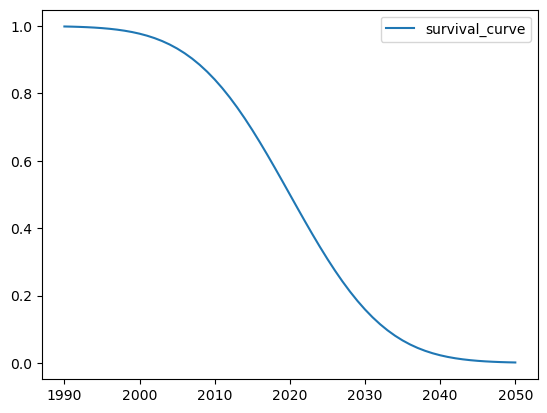

In [6]:
timeseries.plot(y="survival_curve")


<Axes: >

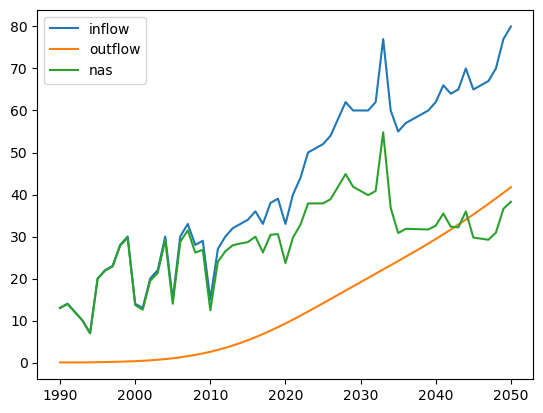

In [7]:
timeseries.plot(y=["inflow", "outflow", "nas"])


<Axes: >

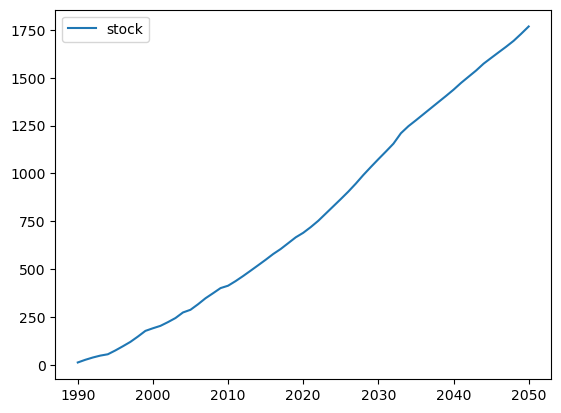

In [8]:
timeseries.plot(y="stock")


<Axes: >

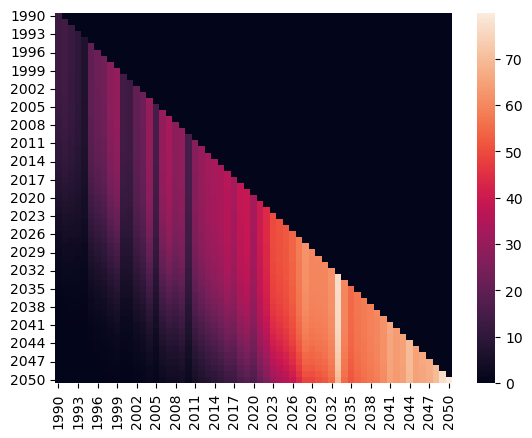

In [9]:
sns.heatmap(cohort, annot=False)

In [10]:
# Explort to excel
writer = pd.ExcelWriter("../data/MFA_II_tutorial_II.xlsx", mode="a")  # 'a' for 'append'
timeseries.to_excel(writer, sheet_name="time_series_flow_driven", index=False)
cohort.to_excel(writer, sheet_name="cohort_flow_driven", index=False)
writer.close()


## Stock driven example

In [11]:
year = data["stock_driven"]["year"].values
stock = data["stock_driven"]["stock"].values
timeseries, cohort = stock_driven_model(time=year, stock=stock, sf_kind="normal")
print(timeseries)


      survival_curve     inflow    outflow  stock  nas
1990        0.998650  20.027034   0.027034     20   20
1991        0.998134   1.011698   0.011698     21    1
1992        0.997445   9.026512   0.026512     30    9
1993        0.996533   9.035813   0.035813     39    9
1994        0.995339   6.043882   0.043882     45    6
...              ...        ...        ...    ...  ...
2046        0.004661  30.600224  17.600224    724   13
2047        0.003467  30.990179  17.990179    737   13
2048        0.002555  31.388660  18.388660    750   13
2049        0.001866  31.795781  18.795781    763   13
2050        0.001350  32.211350  19.211350    776   13

[61 rows x 5 columns]


<Axes: >

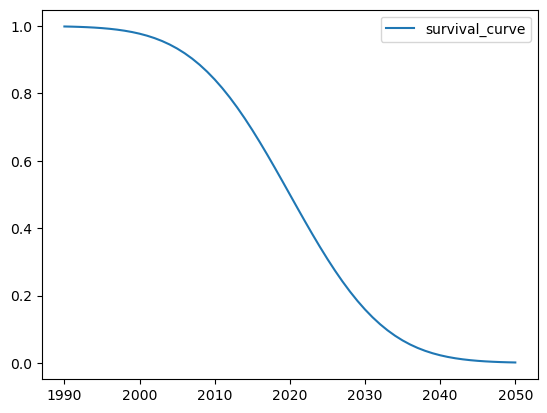

In [12]:
timeseries.plot(y="survival_curve")


<Axes: >

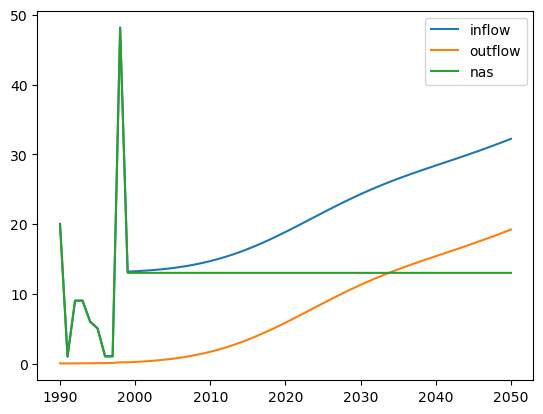

In [13]:
timeseries.plot(y=["inflow", "outflow", "nas"])


<Axes: >

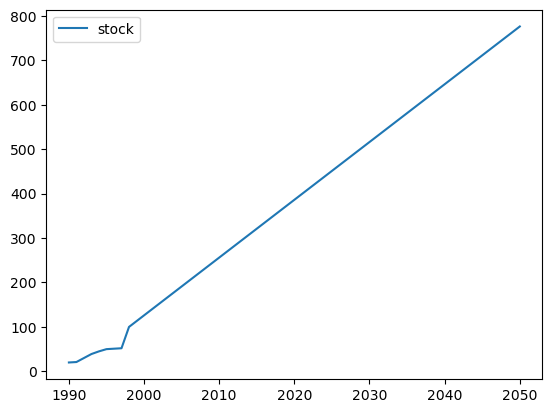

In [14]:
timeseries.plot(y="stock")


<Axes: >

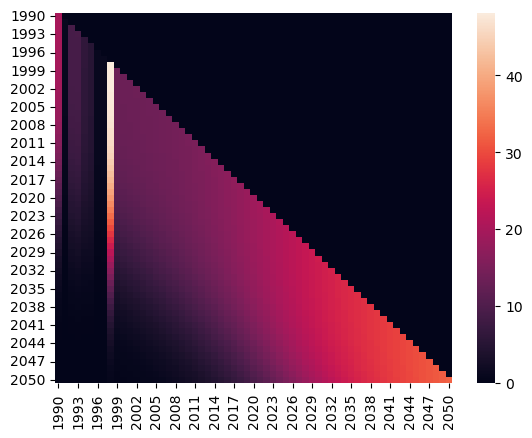

In [15]:
sns.heatmap(cohort, annot=False)

In [16]:
# Explort to excel
writer = pd.ExcelWriter("../data/MFA_II_tutorial_II.xlsx", mode="a")  # 'a' for 'append'
timeseries.to_excel(writer, sheet_name="time_series_stock_driven", index=False)
cohort.to_excel(writer, sheet_name="cohort_stock_driven", index=False)
writer.close()


## Flow driven example 2

Using data from the [Global Material Flows Database](https://www.resourcepanel.org/global-material-flows-database)


In [17]:
FILE_PATH = "../data/mfa4_export.csv"
data = pd.read_csv(FILE_PATH)

In [18]:
# inspect data
data.head(10)

,Country,Category,Flow name,Flow code,Flow unit,1970,1971,1972,1973,1974,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,Biomass,Domestic Extraction,DE,t,29427854.0,28777035.0,27200896.0,29147772.0,30519158.0,...,37198019.0,34018329.0,37907859.0,38097802.0,39503300.0,37422531.0,37951985.0,35170079.0,33170392.0,33681475.0
1,Afghanistan,Biomass,Domestic Material Consumption,DMC,t,29476560.0,29136965.0,27290656.0,29112673.0,30433539.0,...,39001193.0,36654160.0,39953630.0,40324678.0,42368850.0,40730273.0,41903737.0,40132740.0,38165210.0,37202637.0
2,Afghanistan,Biomass,Domestic Material Input,DMI,t,29617873.0,29282898.0,27485608.0,29306247.0,30656605.0,...,39268631.0,36835574.0,40086686.0,40559216.0,42629687.0,41019516.0,42335796.0,40630738.0,39090334.0,38217826.0
3,Afghanistan,Biomass,Exports,EXP,t,141313.0,145933.0,194952.0,193574.0,223066.0,...,267439.0,181414.0,133056.0,234537.0,260837.0,289244.0,432059.0,497998.0,925124.0,1015189.0
4,Afghanistan,Biomass,Imports,IMP,t,190019.0,505863.0,284712.0,158475.0,137447.0,...,2070612.0,2817245.0,2178827.0,2461414.0,3126387.0,3596985.0,4383811.0,5460660.0,5919941.0,4536351.0
5,Afghanistan,Biomass,Physical Trade Balance,PTB,t,48706.0,359930.0,89760.0,-35099.0,-85619.0,...,1803174.0,2635831.0,2045772.0,2226876.0,2865550.0,3307742.0,3951752.0,4962661.0,4994817.0,3521162.0
6,Afghanistan,Biomass,Raw Material Consumption,RMC,t,20572390.0,20415010.0,18274760.0,19127390.0,20290270.0,...,39672800.0,49485190.0,41357150.0,44535280.0,39854990.0,39944650.0,42966490.0,35290920.0,35744010.0,37373780.0
7,Afghanistan,Biomass,Raw Material Equivalents of exports,RME_EXP,t,16001040.0,15485140.0,15970290.0,17176940.0,17773520.0,...,22631320.0,18999510.0,23243330.0,23917280.0,24668770.0,22897510.0,22869920.0,21907100.0,17761630.0,17063460.0
8,Afghanistan,Biomass,Raw Material Equivalents of imports,RME_IMP,t,7145576.0,7123111.0,7044155.0,7156558.0,7544633.0,...,25106100.0,34466370.0,26692620.0,30354760.0,25020470.0,25419630.0,27884420.0,22027940.0,20335240.0,20755770.0
9,Afghanistan,Excavated earthen materials (including soil) nec,Domestic Extraction,DE,t,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
data["Country"].unique()


array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia + Pacific', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curaçao',
       'Cyprus', 'Czechoslovakia', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'DR Congo',
       'Ecuador', 'EECCA', 'Egypt', 'El Salvador', 'Equatorial Guinea',
       'Eritrea', 'Estonia', 'Ethiopia', 'Ethiopia (For

In [20]:
data["Category"].unique()


array(['Biomass', 'Excavated earthen materials (including soil) nec',
       'Fossil fuels', 'Metal ores', 'Mixed and complex products nec.',
       'Non-metallic minerals', 'Products from biomass',
       'Products from fossil fuels', 'Products from metals',
       'Products from non-metallic minerals',
       'Waste for final treatment and disposal'], dtype=object)

In [21]:
data["Flow name"].unique()


array(['Domestic Extraction', 'Domestic Material Consumption',
       'Domestic Material Input', 'Exports', 'Imports',
       'Physical Trade Balance', 'Raw Material Consumption',
       'Raw Material Equivalents of exports',
       'Raw Material Equivalents of imports'], dtype=object)

In [22]:
country = "France"
material = "Non-metallic minerals"
flow_name = "Domestic Material Consumption"


MASK = (
    (data["Country"] == country)
    & (data["Category"] == material)
    & (data["Flow name"] == flow_name)
)
df = data.loc[MASK]
df


,Country,Category,Flow name,Flow code,Flow unit,1970,1971,1972,1973,1974,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
5410,France,Non-metallic minerals,Domestic Material Consumption,DMC,t,367524742.0,367484924.0,372414050.0,403752238.0,419567222.0,...,413717511.0,430776323.0,408084827.0,415097837.0,398440939.0,356628750.0,374200741.0,376036074.0,384137235.0,381136541.0


<Axes: >

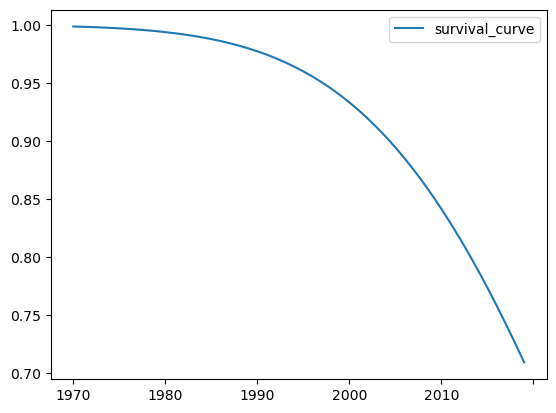

In [23]:
years = [str(yr) for yr in range(1970, 2020)]
flow = df[years].stack().values
lifetime_avg = 60
lifetime_stdv = 20

timeseries, cohort = flow_driven_model(
    time=years, inflow=flow, sf_kind="normal", loc=lifetime_avg, scale=lifetime_stdv
)

timeseries.plot(y="survival_curve")


<Axes: >

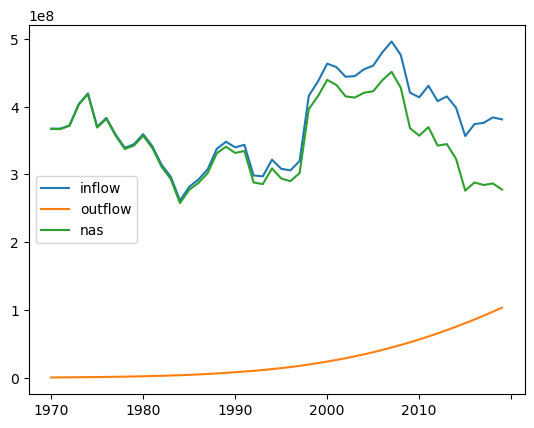

In [24]:
timeseries.plot(y=["inflow", "outflow", "nas"])


<Axes: >

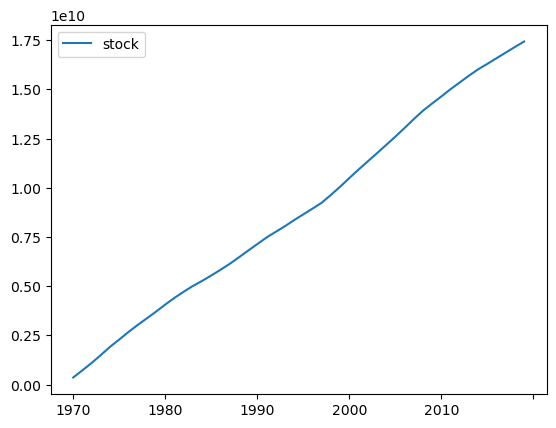

In [25]:
timeseries.plot(y="stock")


<Axes: >

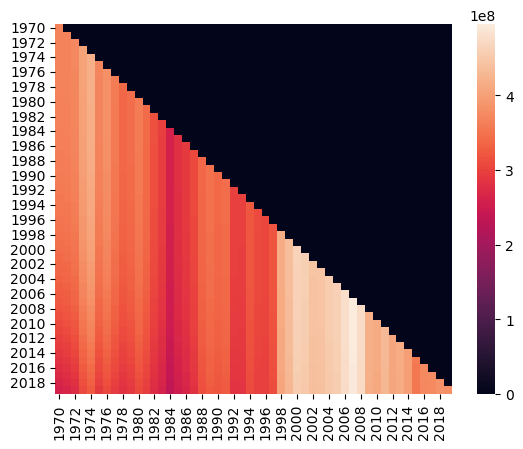

In [26]:
sns.heatmap(cohort, annot=False)